In [146]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/co2-emissions-datamodified/TRAIN.csv
/kaggle/input/co2-emissions-datamodified/TEST.csv
/kaggle/input/ml-olympiad-co2-emissions-prediction-challenge/sample_submission.csv
/kaggle/input/ml-olympiad-co2-emissions-prediction-challenge/train.csv
/kaggle/input/ml-olympiad-co2-emissions-prediction-challenge/test.csv


In [176]:
train1 = pd.read_csv('/kaggle/input/co2-emissions-datamodified/TRAIN.csv')


In [177]:
countries = train1['Country Name'].unique().tolist()

In [178]:
train1 = train1.rename(columns = {'CO2 emissions (metric tons per capita)': 'y', 'year': 'ds'})

In [150]:
train1.head()

,Country Name,ds,y
0,Afghanistan,2000,0.055167
1,Afghanistan,2001,0.055293
2,Afghanistan,2002,0.066810
3,Afghanistan,2003,0.073005
4,Afghanistan,2004,0.054867


In [179]:
train1.isnull().sum()

Country Name      0
ds                0
y               432
dtype: int64

In [152]:
np.max(train1.y)

47.65696201

In [153]:
np.min(train1.y)

0.0

In [181]:
group_avg = train1.groupby('Country Name')['y'].mean().mean()


In [182]:
group_avg

4.2553680663716005

In [183]:
train2 = train1.fillna(group_avg)

In [184]:
train2.isnull().sum()

Country Name    0
ds              0
y               0
dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x7ab9301ad3f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ab9301adcf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ab9301ad930>],
 'medians': [<matplotlib.lines.Line2D at 0x7ab9301aeb60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ab9301ad120>],
 'means': []}

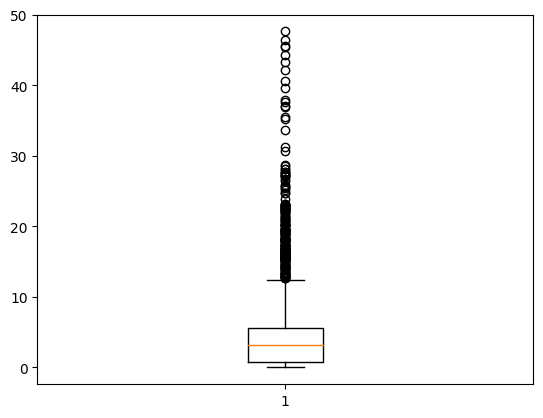

In [185]:
plt.boxplot(train2.y)

**Outliers Handeling Using Z-Score**

In [186]:
#Create a new feature named zscore
mean, sd = train2.y.mean(), train2.y.std()
train2['zscore'] = (train2.y - mean) / sd

In [187]:
train2.head()

,Country Name,ds,y,zscore
0,Afghanistan,2000,0.055167,-0.844646
1,Afghanistan,2001,0.055293,-0.844621
2,Afghanistan,2002,0.066810,-0.842305
3,Afghanistan,2003,0.073005,-0.841059
4,Afghanistan,2004,0.054867,-0.844706


In [163]:
max(train2.zscore)

8.727910390960494

In [164]:
min(train2.zscore)

-0.8557397963790356

In [188]:
#Dataframe without Outliers
train2.loc[abs(train2['zscore']) > 3, 'y'] = group_avg


In [166]:
train2.shape

(4256, 4)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ab9301b3730>,
 'caps': [<matplotlib.lines.Line2D at 0x7ab9301b2d40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ab9301b0550>],
 'medians': [<matplotlib.lines.Line2D at 0x7ab9301b06d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ab9301b08e0>],
 'means': []}

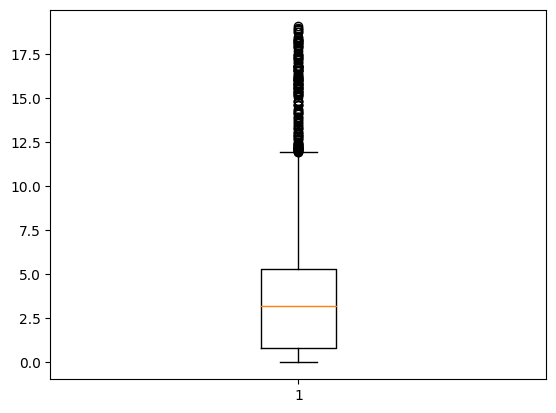

In [189]:
plt.boxplot(train2.y)

In [168]:
train2.head()

,Country Name,ds,y,zscore
0,Afghanistan,2000,0.055167,-0.844646
1,Afghanistan,2001,0.055293,-0.844621
2,Afghanistan,2002,0.066810,-0.842305
3,Afghanistan,2003,0.073005,-0.841059
4,Afghanistan,2004,0.054867,-0.844706


****

In [190]:
def buildModelAndPredictions(train, countries):
    predictions_dfs = []
    for country in countries:
        #new_df named country(e.g, Afghanistan,..)
        df = train[train['Country Name'] == country].iloc[:, 1: ] #keeping just two variable: ds, y
        df['ds'] = pd.to_datetime(df['ds'], format='%Y')
        
        
        #Initialize prophet model
        from prophet import Prophet
        model = Prophet()
        
        model.fit(df)
        future = model.make_future_dataframe(periods=16, freq='YE') # forecasting 16 years into the future
        
        #Forecasting
        forecast = model.predict(future)
        
        #Add new column named 'Country Name' into forecast df
        forecast['Country Name'] = country
        forecast['ds'] = forecast['ds'].dt.year
        
        new_df = forecast[['Country Name', 'ds', 'yhat']]
        
        #return new_df
        
        years_of_interest = [2016, 2017, 2018, 2019, 2020, 2030]
        new_df = new_df[new_df['ds'].isin(years_of_interest)]
        
        #return new_df
        
        new_df2 = new_df.pivot(index = 'Country Name', columns = 'ds', values = 'yhat')
        
        #return new_df2
        new_df3 = new_df2.reset_index()
        new_df3 = new_df3.drop('Country Name', axis = 1)
        new_df3.columns = [f'{col} [YR{col}]' for col in new_df3.columns]
        #return new_df3
        new_df3.insert(0, 'Country Name', country)
        
        predictions_dfs.append(new_df3)
    final_predictions_df = pd.concat(predictions_dfs, axis = 0)
    
    #return predictions_dfs
    return final_predictions_df

In [170]:
train = train2.drop(['zscore'], axis = 1)

In [192]:
train.head()

,Country Name,ds,y
0,Afghanistan,2000,0.055167
1,Afghanistan,2001,0.055293
2,Afghanistan,2002,0.066810
3,Afghanistan,2003,0.073005
4,Afghanistan,2004,0.054867


In [193]:
print(min(train.y), max(train.y))

0.0 19.04291178


In [195]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train['y'] = scaler.fit_transform(train[['y']])


In [196]:
train.head()

,Country Name,ds,y
0,Afghanistan,2000,0.002897
1,Afghanistan,2001,0.002904
2,Afghanistan,2002,0.003508
3,Afghanistan,2003,0.003834
4,Afghanistan,2004,0.002881


**Function Call**

In [197]:
output_df = buildModelAndPredictions(train, countries)

07:48:41 - cmdstanpy - INFO - Chain [1] start processing
07:48:41 - cmdstanpy - INFO - Chain [1] done processing
07:48:41 - cmdstanpy - INFO - Chain [1] start processing
07:48:41 - cmdstanpy - INFO - Chain [1] done processing
07:48:41 - cmdstanpy - INFO - Chain [1] start processing
07:48:41 - cmdstanpy - INFO - Chain [1] done processing
07:48:42 - cmdstanpy - INFO - Chain [1] start processing
07:48:42 - cmdstanpy - INFO - Chain [1] done processing
07:48:42 - cmdstanpy - INFO - Chain [1] start processing
07:48:43 - cmdstanpy - INFO - Chain [1] done processing
07:48:44 - cmdstanpy - INFO - Chain [1] start processing
07:48:44 - cmdstanpy - INFO - Chain [1] done processing
07:48:44 - cmdstanpy - INFO - Chain [1] start processing
07:48:44 - cmdstanpy - INFO - Chain [1] done processing
07:48:44 - cmdstanpy - INFO - Chain [1] start processing
07:48:44 - cmdstanpy - INFO - Chain [1] done processing
07:48:45 - cmdstanpy - INFO - Chain [1] start processing
07:48:45 - cmdstanpy - INFO - Chain [1]

In [198]:
df = output_df

In [199]:
df

,Country Name,2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2030 [YR2030]
0,Afghanistan,0.021549,0.022969,0.024396,0.025830,0.026385,0.038902
0,Africa Eastern and Southern,0.052478,0.053301,0.054445,0.055908,0.051850,0.052561
0,Africa Western and Central,0.022950,0.022808,0.022712,0.022661,0.022218,0.020515
0,Albania,0.094515,0.092151,0.088169,0.082579,0.103575,0.115350
0,Algeria,0.228206,0.240692,0.254540,0.269740,0.257911,0.343654
...,...,...,...,...,...,...,...
0,West Bank and Gaza,0.223462,0.223462,0.223462,0.223462,0.223462,0.223462
0,World,0.252061,0.255166,0.258709,0.262688,0.256061,0.270707
0,"Yemen, Rep.",0.041968,0.040186,0.038581,0.037156,0.041383,0.036827
0,Zambia,0.015105,0.015648,0.016238,0.016875,0.016750,0.021174


In [201]:
original_min = train2['y'].min()
original_max = train2['y'].max()
# Perform descaling
for col in df.columns[1:]:
    df[col] = df[col] * (original_max - original_min) + original_min

In [202]:
df

,Country Name,2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2030 [YR2030]
0,Afghanistan,0.410362,0.437392,0.464565,0.491877,0.502442,0.740806
0,Africa Eastern and Southern,0.999340,1.015009,1.036796,1.064660,0.987381,1.000918
0,Africa Western and Central,0.437035,0.434337,0.432505,0.431536,0.423089,0.390666
0,Albania,1.799837,1.754831,1.678996,1.572541,1.972374,2.196606
0,Algeria,4.345715,4.583478,4.847183,5.136638,4.911375,6.544163
...,...,...,...,...,...,...,...
0,West Bank and Gaza,4.255368,4.255368,4.255368,4.255368,4.255368,4.255368
0,World,4.799982,4.859095,4.926573,5.002339,4.876140,5.155047
0,"Yemen, Rep.",0.799184,0.765253,0.734704,0.707561,0.788049,0.701300
0,Zambia,0.287646,0.297987,0.309224,0.321351,0.318974,0.403208


In [203]:
#df.to_csv('Hacktick_61.csv', index = False)

In [204]:
df.shape

(266, 7)

****==============================================================================================****

**Standardization**

In [56]:
#col = 'CO2 emissions (metric tons per capita)'
#mean, sd = np.mean(train[col]), np.std(train[col])

#train[col] = (train[col] - mean / sd)

In [42]:
#train